In [11]:
import os
import re
import math
import random
import json
import zipfile
import joblib
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class NaiveBayesClassifier:
    def __init__(self):
        self.spam_prob = 0
        self.ham_prob = 0
        self.spam_word_probs = defaultdict(float)
        self.ham_word_probs = defaultdict(float)
        self.vocab = set()

    def save_model(self, file_path='nb_model.joblib'):
        joblib.dump(self, file_path)

    def load_model(self, file_path='nb_model.joblib'):
        loaded_classifier = joblib.load(file_path)
        self.__dict__.update(loaded_classifier.__dict__)

    def preprocess_text(self, text):
        # Simple text preprocessing: lowercase and remove non-alphabetic characters
        text = text.lower()
        text = re.sub(r'[^a-zA-Z ]', '', text)
        return text

    def train(self, training_data):
        spam_count = ham_count = 0
        spam_word_counts = defaultdict(int)
        ham_word_counts = defaultdict(int)

        for text, label in training_data:
            text = self.preprocess_text(text)
            words = text.split()
            for word in words:
                if label == 'spam':
                    spam_word_counts[word] += 1
                else:
                    ham_word_counts[word] += 1
                self.vocab.add(word)

            if label == 'spam':
                spam_count += 1
            else:
                ham_count += 1

        total_emails = spam_count + ham_count
        self.spam_prob = spam_count / total_emails
        self.ham_prob = ham_count / total_emails

        for word in self.vocab:
            # Laplace smoothing to handle unseen words
            self.spam_word_probs[word] = (spam_word_counts[word] + 1) / (spam_count + 2)
            self.ham_word_probs[word] = (ham_word_counts[word] + 1) / (ham_count + 2)

    def predict(self, text):
        text = self.preprocess_text(text)
        words = text.split()

        spam_score = math.log(self.spam_prob)
        ham_score = math.log(self.ham_prob)

        for word in words:
            if word in self.vocab:
                spam_score += math.log(self.spam_word_probs[word])
                ham_score += math.log(self.ham_word_probs[word])

        confidence = abs(spam_score - ham_score)

        # Classify as spam if the spam_score is greater
        predicted_class = 'spam' if spam_score > ham_score else 'ham'

        return {'prediction': predicted_class, 'confidence': confidence}


    def train_from_directory(self, zip_file_path):
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall('./')

        directory = './emails'

        ham_folder = os.path.join(directory, 'ham')
        spam_folder = os.path.join(directory, 'spam')

        ham_emails = [(self.read_email(os.path.join(ham_folder, f)), 'ham') for f in os.listdir(ham_folder)]
        spam_emails = [(self.read_email(os.path.join(spam_folder, f)), 'spam') for f in os.listdir(spam_folder)]

        # Split emails into training, validation, and test sets
        random.shuffle(ham_emails)
        random.shuffle(spam_emails)

        ham_train_size = int(0.7 * len(ham_emails))
        spam_train_size = int(0.7 * len(spam_emails))

        training_data = ham_emails[:ham_train_size] + spam_emails[:spam_train_size]
        validation_data = ham_emails[ham_train_size:] + spam_emails[spam_train_size:]

        # Update the vocab based on the new data
        self.train(training_data)

        # Save the model to a JSON file
        model_data = {
            'spam_prob': self.spam_prob,
            'ham_prob': self.ham_prob,
            'spam_word_probs': dict(self.spam_word_probs),
            'ham_word_probs': dict(self.ham_word_probs),
            'vocab': list(self.vocab)
        }

        with open('nb_model.json', 'w') as json_file:
            json.dump(model_data, json_file)

        return validation_data

    def evaluate_model(self, validation_data):
        test_texts, true_labels = zip(*validation_data)
        results = [self.predict(text) for text in test_texts]
        predicted_labels = [result['prediction'] for result in results]

        # Calculate metrics
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels, pos_label='spam')
        recall = recall_score(true_labels, predicted_labels, pos_label='spam')
        f1 = f1_score(true_labels, predicted_labels, pos_label='spam')

        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")

        return accuracy, precision, recall, f1

    def read_email(self, file_path):
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            return file.read()

    def plot_most_common_words(self, class_label, num_words=10, min_word_length=4):
        if class_label == 'spam':
            word_probs = self.spam_word_probs
        elif class_label == 'ham':
            word_probs = self.ham_word_probs
        else:
            raise ValueError("Invalid class label. Use 'spam' or 'ham'.")

        filtered_words = [word for word in word_probs if len(word) > min_word_length]

        # Sort filtered words by probability
        sorted_words = sorted(filtered_words, key=word_probs.get, reverse=True)[:num_words]
        probabilities = [word_probs[word] for word in sorted_words]

        plt.figure(figsize=(10, 6))
        sns.barplot(x=probabilities, y=sorted_words, palette='viridis')
        plt.title(f"Top {num_words} Words for {class_label.capitalize()}")
        plt.xlabel("Probability")
        plt.ylabel("Word")
        plt.show()


# # Small example:
# training_data = [("Buy now, limited offer!", "spam"), ("Meeting at 2 pm tomorrow", "ham")]
# test_email = "Special offer just for you!"
# classifier = NaiveBayesClassifier()
# classifier.train(training_data)
# prediction = classifier.predict(test_email)
# print(f"The email is classified as: {prediction}")


In [12]:
classifier = NaiveBayesClassifier()
validation_data = classifier.train_from_directory('emails.zip')
classifier.save_model()
classifier.evaluate_model(validation_data)

Accuracy: 0.90
Precision: 1.00
Recall: 0.80
F1 Score: 0.89


(0.9, 1.0, 0.8, 0.888888888888889)

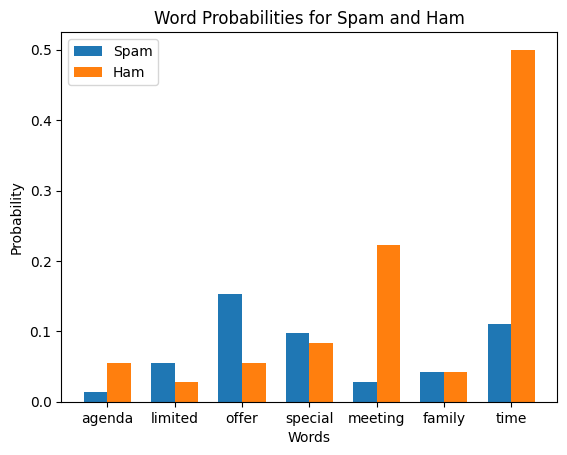

In [13]:
import numpy as np

def plot_word_probabilities(classifier, word_list):
    spam_probs = []
    ham_probs = []

    for word in word_list:
        if word in classifier.vocab:
            spam_probs.append(classifier.spam_word_probs[word])
            ham_probs.append(classifier.ham_word_probs[word])
        else:
            # If the word is not in the vocabulary, assume a small default probability
            spam_probs.append(0.0001)
            ham_probs.append(0.0001)

    # Plot the probabilities for each word
    bar_width = 0.35
    index = np.arange(len(word_list))

    plt.bar(index, spam_probs, bar_width, label='Spam')
    plt.bar(index + bar_width, ham_probs, bar_width, label='Ham')

    plt.xlabel('Words')
    plt.ylabel('Probability')
    plt.title('Word Probabilities for Spam and Ham')
    plt.xticks(index + bar_width / 2, word_list)
    plt.legend()
    plt.show()

word_list = ['agenda', 'limited', 'offer', 'special', 'meeting', 'family', 'time']
plot_word_probabilities(classifier, word_list)

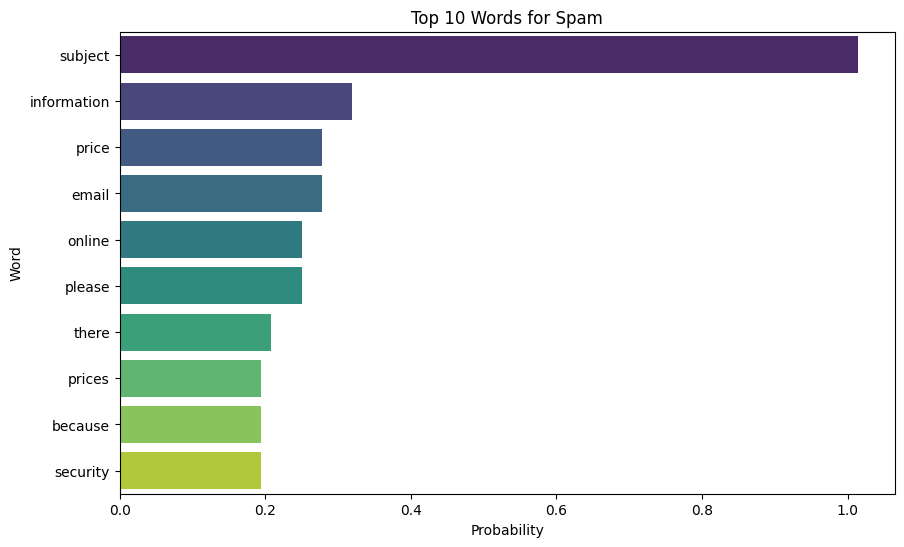

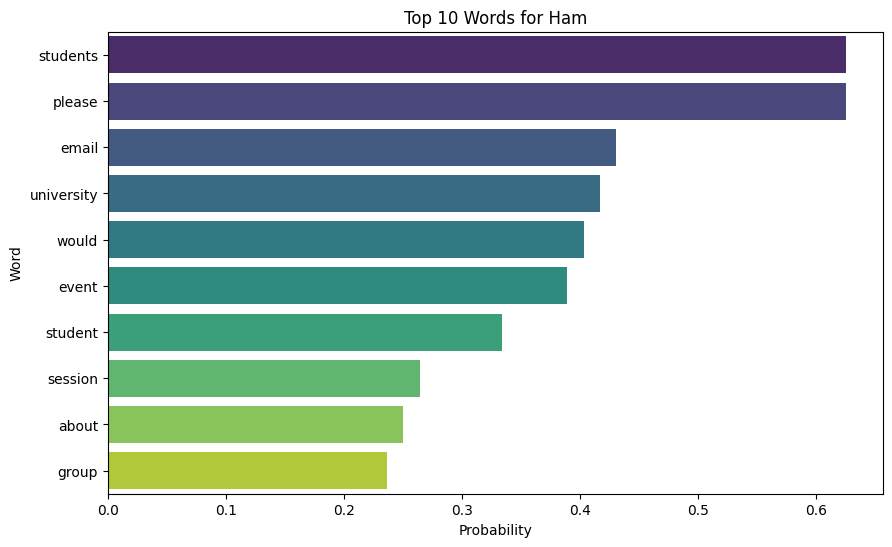

In [14]:
classifier.plot_most_common_words('spam', num_words=10, min_word_length=4)
classifier.plot_most_common_words('ham', num_words=10, min_word_length=4)

In [5]:
email_1 = """
Thank you for your purchase. We appreciate your business and want to ensure your satisfaction.

    To show our appreciation, we're offering you an exclusive discount on your next purchase. Simply use the promo code THANKYOU15 at checkout to enjoy a 15% discount on your entire order.

    This special offer is valid for the next 7 days, so don't miss out. Shop now and save on your favorite products!

    [Shop Now]

    We look forward to serving you again soon.

    Best regards,
    Customer Support Team
"""

email_2 = """
Limited-time Offer: Save 50% Today!

      Congratulations! You've been selected for an exclusive limited-time offer. Shop now and enjoy a 50% discount on a wide range of products.

      Use code SAVE50 at checkout to claim your discount. This offer is very real and valid until 31st December. Don't miss out on the savings.

      Visit our online store and start shopping today!

      [Shop Now]

      Yours sincerely,
      Nigerian prince
"""

prediction_1 = classifier.predict(email_1)
prediction_2 = classifier.predict(email_2)

print(f"Prediction for Email 1: {prediction_1}")
print(f"Prediction for Email 2: {prediction_2}")


Prediction for Email 1: {'prediction': 'ham', 'confidence': 7.645161601087153}
Prediction for Email 2: {'prediction': 'spam', 'confidence': 4.786277463639024}


In [ ]:
import math
import os

with zipfile.ZipFile('emails_split.zip', 'r') as zip_ref:
            zip_ref.extractall('./')

def words(filename):
	# Get list of lines
	infile = open(filename,'r')
	lines = infile.readlines()
	infile.close()

	# For each line, delimit word by space
	# and add to list of words. Also, convert
	# all words to lowercase for convenience
	return [word.strip().lower() for line in lines for word in line.split()]

def lexicon(k):
	# Extract training directories
	spam_training_directory = os.getcwd() + '/emails_split/spam'
	ham_training_directory  = os.getcwd() + '/emails_split/ham'

	# Create spam distribution
	spam_distribution = {}
	files = os.listdir(spam_training_directory)
	for file in files:
		list_of_words = words(spam_training_directory + '/' + file)
		for word in list_of_words:
			if word in spam_distribution:
				spam_distribution[word] += 1
			else:
				spam_distribution[word] = 1

	# Create ham distribution
	ham_distribution = {}
	files = os.listdir(ham_training_directory)
	for file in files:
		list_of_words = words(ham_training_directory + '/' + file)
		for word in list_of_words:
			if word in ham_distribution:
				ham_distribution[word] += 1
			else:
				ham_distribution[word] = 1

	# Remove all key,value pairs that
	# have a value less than k
	hamkeys  = list(ham_distribution.keys())
	spamkeys = list(spam_distribution.keys())

	for key in spamkeys:
		if spam_distribution[key] < k:
			del spam_distribution[key]

	for key in hamkeys:
		if ham_distribution[key] < k:
			del ham_distribution[key]

	return ham_distribution, spam_distribution

def probability(word, category, ham_distribution, spam_distribution, m):
	# Compute P(w = word | category), smoothing the result
	# with Laplacian Smoothing with parameter m

	distribution = ham_distribution if category == 'ham' else spam_distribution

	V = len(distribution)

	keys = distribution.keys()

	numerator = (distribution[word] + m if word in keys else m)
	denominator = sum([distribution[key] for key in keys]) + m*V

	return numerator / float(denominator)

def classify_email(email, ham_distribution, spam_distribution, m):
	email_words = words(email)

	ham_probability  = 0
	spam_probability = 0

	for word in email_words:
		ham_probability  += math.log(probability(word, 'ham', ham_distribution, spam_distribution, m))
		spam_probability += math.log(probability(word, 'spam', ham_distribution, spam_distribution, m))

	return 'ham' if ham_probability > spam_probability else 'spam'

def test_filter(hamtesting, spamtesting, k, m):
	ham_distribution, spam_distribution = lexicon(k)

	spam_as_ham = []
	ham_as_spam = []

	ham_hit   = 0
	ham_total = 0
	ham_testing_files = os.listdir(hamtesting)
	for file in ham_testing_files:
		if classify_email(hamtesting + '/' + file, ham_distribution, spam_distribution, m) == 'ham':
			ham_hit += 1
		else:
			ham_as_spam.append(file)
		ham_total += 1

	spam_hit   = 0
	spam_total = 0
	spam_testing_files = os.listdir(spamtesting)
	for file in spam_testing_files:
		if classify_email(spamtesting + '/' + file, ham_distribution, spam_distribution, m) == 'spam':
			spam_hit += 1
		else:
			spam_as_ham.append(file)
		spam_total += 1

	ham_hit_ratio  = ham_hit / float(ham_total)
	spam_hit_ratio = spam_hit / float(spam_total)

	return ham_hit_ratio, spam_hit_ratio, ham_total, spam_total, ham_as_spam, spam_as_ham

# ---------- CODE STARTS HERE ----------

spamtesting = os.getcwd() + '/emails_split/spam_test'
hamtesting  = os.getcwd() + '/emails_split/ham_test'

ham_hit_ratio, spam_hit_ratio, ham_total, spam_total, ham_as_spam, spam_as_ham = test_filter(hamtesting, spamtesting, k=5, m=1)

print ()
print ("Correct Ham Percentage:     ", ham_hit_ratio * 100)
print ("Correct Spam Percentage:    ", spam_hit_ratio * 100)
print ("Correct Overall Percentage: ", (ham_hit_ratio*ham_total + spam_hit_ratio*spam_total) / (ham_total + spam_total) * 100)

print ("\nHam Incorrectly Labelled as Spam:")
for file in ham_as_spam:
	print ("\t"+file)

print ("\nSpam Incorrectly Labelled as Ham:")
for file in spam_as_ham:
	print ("\t"+file)
print


Correct Ham Percentage:      100.0
Correct Spam Percentage:     80.95238095238095
Correct Overall Percentage:  90.47619047619048

Ham Incorrectly Labelled as Spam:

Spam Incorrectly Labelled as Ham:
	spam2.txt
	spam1.txt
	spam13.txt
	spamSample.txt


<function print>